In [1]:
#---- parts taken from https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py
#--- look there for nice graphics!

import numpy as np
import matplotlib.pyplot as plt

n_samples = 225
n_outliers = 25
n_features = 2

#------ the following generates a collection of data in R^2, the "inliers", mostly coming from one
#------ normal distribution, then adds "erroneous" data, the "outliers", from another distribution

# generate data
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
# the following generates n_samples many vectors in R^{n_features}=R^2 using a
# normal distribution with mean (0,0) (because not specified otherwise) and
# covariance matrix gen_cov times gen_cov^T
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)
# I don't know of a command that directly produces normal distributions with given mean and covariance matrix.
# Instead one can produce _standard_ normally distributed data (i.e. mean zero, covariance matrix I),
# in other words a sequence of independent normally distributed univariate data,
# with the above command: np.random.randn(n_samples, n_features)
# Then transform the result by multiplying with the "square root" of the desired covariance matrix
# using the following formula: If X ~ N(x|m,S) then AX ~ N(x|Am, ASA^T) -- see the paragraph
# before Remark 4.8.10 of the notes.
print('Data points normally distributed with mean zero and the following covariance matrix:\n',np.dot(gen_cov,gen_cov.T))

# As a check let's compute the empirical mean vector and the empirical covariance matrix of the data
# that we generated:
print('Mean of the data:\n[',np.mean(X.T[0]),', ',np.mean(X.T[1]), ']')
print('Empirical covariance matrix:\n',np.cov(X.T))
# I use the transpose because np.cov by default interprets the elements of the nth row
# as the nth coordinates of the samples, but our X is the other way round.
# One could also use np.cov(X, rowvar=False) with the same effect.

# we replace the last 25 data points by some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
print('\n Outliers normally distributed with mean zero and the following covariance matrix:\n',np.dot(outliers_cov,outliers_cov.T))
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)


Data points normally distributed with mean zero and the following covariance matrix:
 [[4. 0.]
 [0. 1.]]
Mean of the data:
[ 0.02737964342451363 ,  0.017560645648099074 ]
Empirical covariance matrix:
 [[4.14156863 0.12668981]
 [0.12668981 0.85031433]]

 Outliers normally distributed with mean zero and the following covariance matrix:
 [[ 1.  0.]
 [ 0. 49.]]


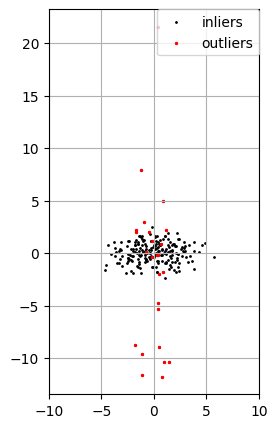

In [67]:
# Draw the data set in a scatter plot
# This function takes two arrays of vectors of length 2 and draws them in a scatter plot
# the first list is drawn as black points, labeled 'inliers',
# the second list is drawn as red points, labeled 'outliers'
# one only needs to pass one list, the second is optional

def draw_points(Points,Outliers=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    # Plot data set
    inlier_plot = ax.scatter(Points[:, 0], Points[:, 1],
                         color='black', label='inliers', s=1)
    if not(Outliers is None):
        outlier_plot = ax.scatter(Outliers[:, 0], Outliers[:, 1],
                          color='red', label='outliers',s=2)
    ax.set_xlim(ax.get_xlim()[0], 10.)


    # Create meshgrid of feature 1 and feature 2 values
    xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
    zz = np.c_[xx.ravel(), yy.ravel()]

    # Add legend
    if not(Outliers is None):
        ax.legend([inlier_plot, outlier_plot],
                  ['inliers', 'outliers'],
                  loc="upper right", borderaxespad=0)

    ax.grid()
    ax.set_xlim(-10, 10)
    ax.set_aspect("equal")
    plt.show()


draw_points(X, X[-n_outliers: ,:])


1. Mean of the contaminated data:
[ -0.02064438485434053 ,  -0.110654578206426 ]
2. Empirical covariance matrix of the contaminated data:
 [[3.76456378 0.05933763]
 [0.05933763 6.92966405]]


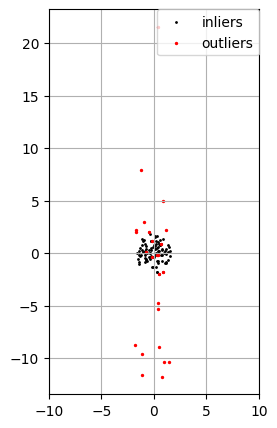

In [68]:
#-- X is now the collection of all the data vectors.
# Your task: Try to filter out the outliers from X, at least the bad ones,
# without using that you know which elements of X are outliers.

# ------------ General idea for finding outliers:-------------
# 1. Compute the mean m of the data
# 2. Compute the empirical covariance matrix C of the data
# 3. Use it to define a distance between data points x and y:
#     the square root of (x-y)^T C^(-1) (x-y) is called the Mahalanobis distance from x to y)
# # The Mahalanobis distance can be seen as a metric (coming from an inner product given by C)
# that is inherent in the data. This point of view is very nicely explained in the first answer of this forum post:
# https://stats.stackexchange.com/questions/62092/bottom-to-top-explanation-of-the-mahalanobis-distance?rq=1&newreg=bc22f22ed57045d6be2d6adbee05e3a1
#
# 4. Now the idea is that outliers are those points that lie "far away" from the mean according to this metric.
# "Far away" is of course not precise, but for example if one can safely assume that not more than 1/5 of
# the data points are outliers, one can simply take the 4/5 of the points that are closest to the mean
# and declare this subset free of outliers.
# For this exercise we just search for 100 points of which we want to be pretty sure that they are not outliers.

print('1. Mean of the contaminated data:\n[',np.mean(X.T[0]),', ',np.mean(X.T[1]), ']')
print('2. Empirical covariance matrix of the contaminated data:\n',np.cov(X.T))


# -------Your task (part a):--------
# a)  Find the 100 points that are closest to the mean, in the sense described above, and plot them.
C = np.cov(X.T, ddof=1)
mean = np.mean(X,axis=0)
C_inv = np.linalg.inv(C)
dist = np.sqrt(np.diagonal(X@C_inv@X.T))
top_100_indices = dist.argsort()[:100]
draw_points(X[top_100_indices], X[-n_outliers:, :])


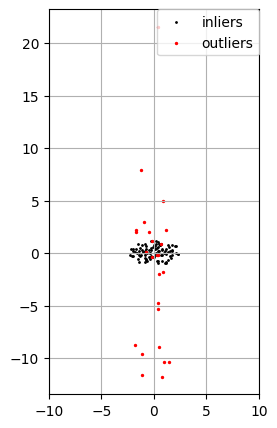

In [113]:
# The problem with this procedure is that the covariance matrix, which we use to define the distance
# by which we then want to detect outliers, already is itself defined in terms of the contaminated data.
# You can see above that is pretty different from the covariance matrix of the uncontaminated data.

# A remedy that seems to work well in practice is to first find a better estimator for the uncontaminated
# covariance matrix.


# This estimator is called the Minimum Covariance Determinant Estimator.
# It is computed as follows:

# 1. Try to find that 100-element subset of X whose covariance matrix has the smallest determinant
# Instead of really checking through all subsets, rather choose randomly 10000 such subsets
# and take the one with smallest covariance matrix determinant out of these. Call it X_1.
# --- you can e.g. use  sklearn.model_selection.train_test_split  for this random subset picking,
# or np.random.choice for randomly picking indices between 0 and 124.

# Then:
# 2. compute the mean of X_1; call it m_1
# 3. compute the empirical covariance matrix of X_1; call it C_1
# This is the estimate for the covariance matrix of the uncontaminated data.

# To remove outliers go on as follows:
# 4. For each point x of our original X compute (x-m_1)^T C_1^(-1) (x-m_1)
#        (let's call the square root of this number the C_1-Mahalanobis distance from x to m_1)
# 5. Take the 100 points with smallest C_1-Mahalanobis distance from m_1.


# -------Your task (part b):--------
# b) Do these steps.
#    Then plot the resulting set of 100 points.
det = np.inf
for i in range(10000):
    indices = np.random.choice(range(len(X)), 100)
    det_temp = np.linalg.det(np.cov(X[indices].T, ddof=1))
    if det >= det_temp:
        det = det_temp
        selected_indices = indices

X_1 = X[selected_indices]
m_1 = np.mean(X_1)
C_1 = np.cov(X_1.T, ddof=1)
print(C_1)
C_1inv = np.linalg.inv(C_1)
dist = np.sqrt(np.diagonal(X@C_1inv@X.T))
top_100_indices = dist.argsort()[:100]
draw_points(X[top_100_indices], X[-n_outliers:, :])


In [71]:
# ABOUT USING THE Minimum Covariance Determinant Estimator IN PRACTICE:
# In practice for this whole procedure one would simply use the following command:
from sklearn.covariance import MinCovDet
robust_cov = MinCovDet().fit(X)
# This directly does several iterations of the above process, I think...
robust_cov.covariance_


array([[3.72315755, 0.11620868],
       [0.11620868, 0.93786839]])

The results are still a bit off from [[4, 0], [0, 1]]